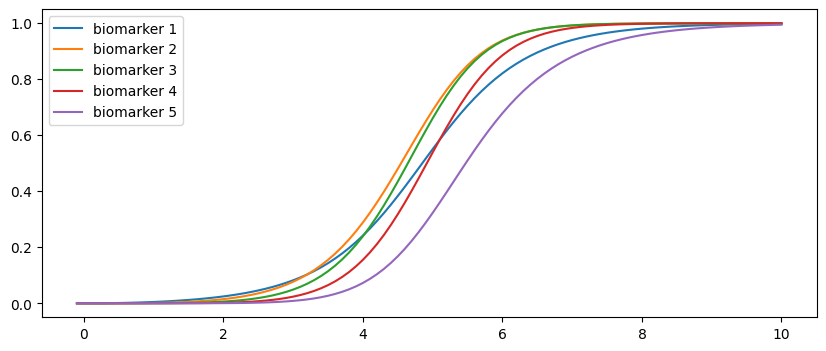

[[0. 1. 0. 0. 0.]
 [1. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 1.]
 [0. 0. 0. 1. 0.]]


In [2]:
import numpy as np
import matplotlib.pyplot as plt

def get_adjacency_matrix(connectivity_matrix_type, n_biomarkers):
    if connectivity_matrix_type == 'offdiag':
        matrix = np.zeros((n_biomarkers, n_biomarkers))
        for i in range(n_biomarkers - 1):
            matrix[i, i + 1] = 1
            matrix[i + 1, i] = 1
    else:
        raise ValueError("Unknown connectivity matrix type")
    return matrix

def multi_logistic_deriv_force(K, f, x):
    return np.dot(np.eye(K.shape[0]) - np.diag(x), np.dot(K, x) + f)

def generate_logistic_model(n_biomarkers=10, step=0.1, n_steps=100, neg_frac=0.01, connectivity_matrix_type='offdiag'):
    t0 = -neg_frac * n_steps * step
    t = np.arange(t0, (n_steps + 1) * step, step)
    
    x0 = np.zeros(n_biomarkers)
    f = np.zeros(n_biomarkers)
    f[0] = 0.01
    
    x = np.zeros((n_biomarkers, len(t)))
    zero_ind = np.where(t == 0)[0][0]
    x[:, zero_ind] = x0

    K = get_adjacency_matrix(connectivity_matrix_type, n_biomarkers)
    
    # backward integration
    for i in range(zero_ind - 1, -1, -1):
        force = np.zeros_like(f)
        dx_dt = multi_logistic_deriv_force(K, force, x[:, i + 1])
        x[:, i] = np.maximum(0, x[:, i + 1] - dx_dt * step)

    # forward integration
    for i in range(zero_ind, n_steps + zero_ind):
        force = np.exp(t[i] * f) - 1
        dx_dt = multi_logistic_deriv_force(K, force, x[:, i])
        x[:, i + 1] = x[:, i] + dx_dt * step

    return t, x, K

n_biomarkers = 5
t, x, K = generate_logistic_model(n_biomarkers=n_biomarkers)

plt.figure(figsize=(10, 4))
for i in range(n_biomarkers):
    plt.plot(t, x[i], label=f'biomarker {i+1}')
plt.legend()
plt.show()


print(K)


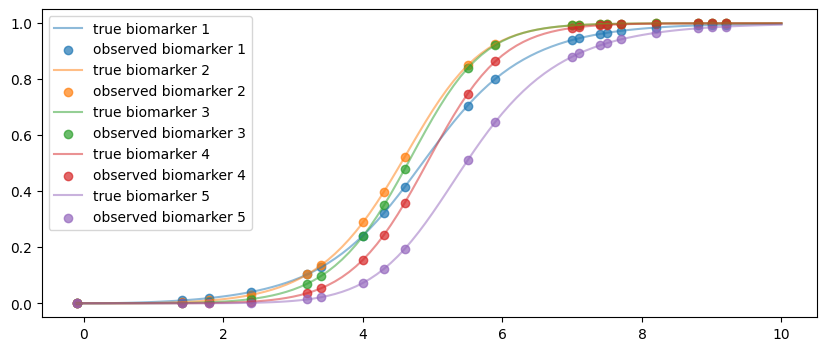

In [3]:
np.random.seed(1)
t, x_true, _ = generate_logistic_model(n_biomarkers=5)


noise_level = 0.00
x_obs = x_true + np.random.normal(0, noise_level, x_true.shape)


n_obs = 20
obs_indices = np.random.choice(len(t), size=n_obs, replace=False)
obs_indices.sort()
t_obs = t[obs_indices]
x_obs = x_obs[:, obs_indices]
x_obs = x_obs.clip(0,1)

plt.figure(figsize=(10, 4))
for i in range(x_obs.shape[0]):
    plt.plot(t, x_true[i], label=f"true biomarker {i+1}", alpha=0.5)
    plt.scatter(t_obs, x_obs[i], label=f"observed biomarker {i+1}", alpha=0.7)
plt.legend()
plt.show()

### multi-fit 2nd approach.
At this stage I have the patient observations which are from the noise ground truth progression curves. We are interested in:
- forcing terms/forcing function
- initial conditions/inital values
- the connectivity matrix (but only the parts that matters i.e. the off-diagonal)

we need to guess, ~~the initial conditions~~, the forcing terms, and then the "physiological relevent parts of `K`"

**UPDATE:** just going to assume all initial conditions are 0, optimization always picked max bound for all biomarkers. Will come back

guess the parameters, then solve the logistic ODE, and then compute the residual between `x_obs` and `x_pred @ time t_obs`, will then minimize that.

Fitted Forcing Function (f): [ 0.01770754 -0.00817714  0.00023827  0.0003655   0.00043771]


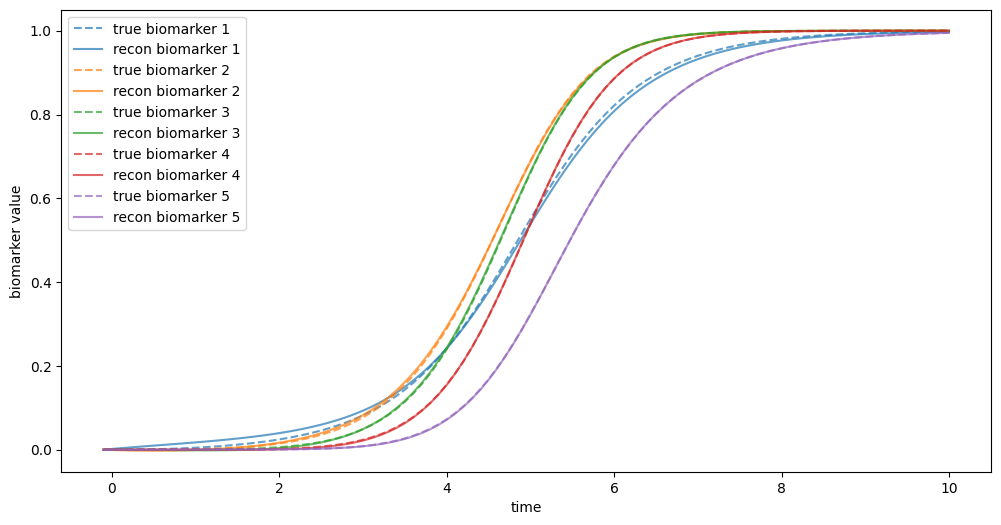

In [33]:
from scipy.optimize import minimize

def lsq_x0(params, t_obs, x_obs, K, x0_fixed=None, step=0.1, t_span=None):
    
    n_biomarkers = x_obs.shape[0]

    # if x0_fixed is None, it means we are optimizing both x0 (initial conditions) and f (forcing terms)
    # so we split the params array into the first n_biomarkers (x0) and the rest (f)
    # otherwise, if x0_fixed is provided, we don't optimize x0 and use it directly, only optimizing f
    if x0_fixed is None:
        x0 = params[:n_biomarkers]
        f = params[n_biomarkers:]
    else:
        x0 = x0_fixed
        f = params

    x_pred = np.zeros((n_biomarkers, len(t_obs)))
    x = np.zeros((n_biomarkers, len(t_span)))
    x[:, 0] = x0

    for i in range(len(t_span) - 1):
        dx_dt = multi_logistic_deriv_force(K, f, x[:, i])
        x[:, i + 1] = x[:, i] + dx_dt * step

    # interpolation to match observed timing
    for j in range(n_biomarkers):
        x_pred[j] = np.interp(t_obs, t_span, x[j])

    # compute residuals
    residuals = x_obs.flatten() - x_pred.flatten()
    return residuals

# initiate guesses, just guessing zeroes
f_guess = np.zeros(n_biomarkers)
x0_fixed = np.zeros(n_biomarkers)  

## optimization

result = minimize(
    lambda params: np.sum(lsq_x0(params, t_obs, x_obs, K, x0_fixed=x0_fixed, step=0.1, t_span=t)**2),
    f_guess,
    method="L-BFGS-B",
    bounds=[(-0.1, 0.1)] * n_biomarkers
)

f_fit = result.x
print("Fitted Forcing Function (f):", f_fit)

# plot reconstruction
def reconstruct_trajectories(x0, f, K, t, step=0.1):
    n_biomarkers = len(x0)
    x_reconstructed = np.zeros((n_biomarkers, len(t)))
    x_reconstructed[:, 0] = x0

    for i in range(len(t) - 1):
        dx_dt = multi_logistic_deriv_force(K, f, x_reconstructed[:, i])
        x_reconstructed[:, i + 1] = x_reconstructed[:, i] + dx_dt * step

    return x_reconstructed

x_reconstructed = reconstruct_trajectories(x0_fixed, f_fit, K, t)

colors = plt.cm.tab10.colors

plt.figure(figsize=(12, 6))

for i in range(x_true.shape[0]):
    plt.plot(t, x_true[i], label=f"true biomarker {i+1}", linestyle="--", alpha=0.7, color=colors[i])
    plt.plot(t, x_reconstructed[i], label=f"recon biomarker {i+1}", alpha=0.7, color=colors[i])
plt.xlabel("time")
plt.ylabel("biomarker value")
plt.legend()
plt.show()

fitted x0:  [0.00000000e+00 4.23615342e-08 1.58552731e-04 8.66379296e-04
 7.59656685e-04]
true x0:  [0. 0. 0. 0. 0.]


fitted f:  [ 1.29190766e-02 -2.04540276e-03 -4.53232780e-03  6.97236021e-05
  2.16908802e-04]
true f:  [0.01 0.   0.   0.   0.  ]


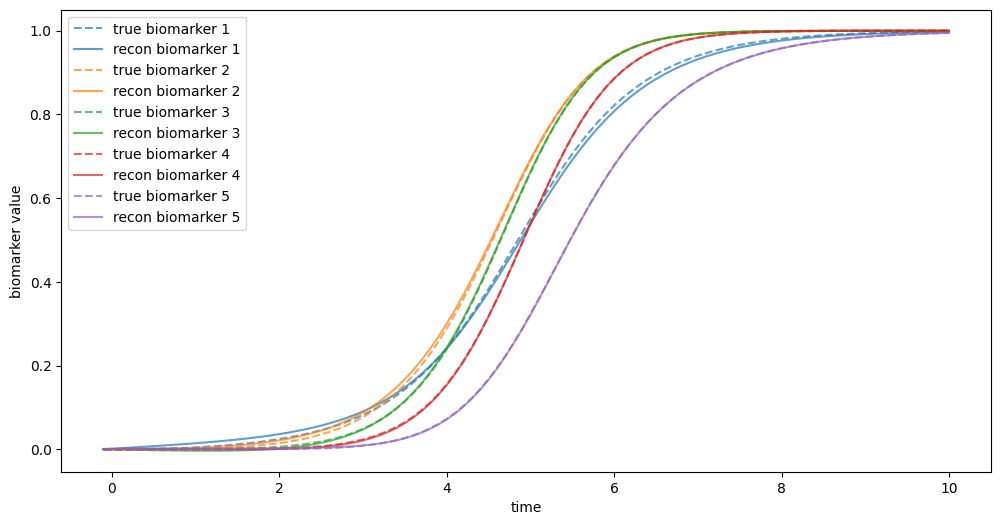

In [37]:
from scipy.optimize import minimize

def lsq_x0(params, t_obs, x_obs, K, step=0.1, t_span=None):
    
    n_biomarkers = x_obs.shape[0]

    # if x0_fixed is None, it means we are optimizing both x0 (initial conditions) and f (forcing terms)
    # so we split the params array into the first n_biomarkers (x0) and the rest (f)
    # otherwise, if x0_fixed is provided, we don't optimize x0 and use it directly, only optimizing f
    x0 = params[:n_biomarkers]
    f = params[n_biomarkers:]

    x_pred = np.zeros((n_biomarkers, len(t_obs)))
    x = np.zeros((n_biomarkers, len(t_span)))
    x[:, 0] = x0 # set initial conditions

    # forward integration
    for i in range(len(t_span) - 1):
        dx_dt = multi_logistic_deriv_force(K, f, x[:, i])
        x[:, i + 1] = x[:, i] + dx_dt * step

    # interpolation to match observed timing
    for j in range(n_biomarkers):
        x_pred[j] = np.interp(t_obs, t_span, x[j])

    # compute residuals
    residuals = x_obs.flatten() - x_pred.flatten()
    return residuals

# initial guesses x0 and f
x0_guess = np.zeros(n_biomarkers)  # assume biomarkers start close to 0, BUT NOT BELOW ZERO
f_guess = np.zeros(n_biomarkers)  # forcing terms guessed as zeroes

# combine guesses into one array for optimization
params_guess = np.concatenate([x0_guess, f_guess])

# set bounds for x0 and f (x0 between 0 and 0.05, f between -0.1 and 0.1)
bounds = [(0, 0.05)] * n_biomarkers + [(-0.1, 0.1)] * n_biomarkers

## optimization

result = minimize(
    lambda params: np.sum(lsq_x0(params, t_obs, x_obs, K, step=0.1, t_span=t)**2),
    params_guess,
    method="L-BFGS-B",
    bounds=bounds
)

x0_fit = result.x[:n_biomarkers]
f_fit = result.x[n_biomarkers:]

# copied from disease instantiation
x0_true = np.zeros(n_biomarkers)
f_true = np.zeros(n_biomarkers)
f_true[0] = 0.01

print("fitted x0: ", x0_fit)
print("true x0: ", x0_true)
print("\n")
print("fitted f: ", f_fit)
print("true f: ", f_true)

# reconstruction
def reconstruct_trajectories(x0, f, K, t, step=0.1):
    n_biomarkers = len(x0)
    x_reconstructed = np.zeros((n_biomarkers, len(t)))
    x_reconstructed[:, 0] = x0

    for i in range(len(t) - 1):
        dx_dt = multi_logistic_deriv_force(K, f, x_reconstructed[:, i])
        x_reconstructed[:, i + 1] = x_reconstructed[:, i] + dx_dt * step

    return x_reconstructed

x_reconstructed = reconstruct_trajectories(x0_fit, f_fit, K, t)

colors = plt.cm.tab10.colors

plt.figure(figsize=(12, 6))

for i in range(x_true.shape[0]):
    plt.plot(t, x_true[i], label=f"true biomarker {i+1}", linestyle="--", alpha=0.7, color=colors[i])
    plt.plot(t, x_reconstructed[i], label=f"recon biomarker {i+1}", alpha=0.7, color=colors[i])

plt.xlabel("time")
plt.ylabel("biomarker value")
plt.legend()
plt.show()


fitted x0:  [0.00169037 0.02992711 0.02948188 0.02594278 0.00580088]
true x0:  [0. 0. 0. 0. 0.]


fitted f:  [ 0.00303095 -0.04088757 -0.03718622 -0.0496442  -0.00437091]
true f:  [0.01 0.   0.   0.   0.  ]


fitted K: 
 [[0.         0.90211286 0.         0.         0.        ]
 [0.90211286 0.         0.85438762 0.         0.        ]
 [0.         0.85438762 0.         0.85257603 0.        ]
 [0.         0.         0.85257603 0.         0.89125365]
 [0.         0.         0.         0.89125365 0.        ]]
true K: 
 [[0. 1. 0. 0. 0.]
 [1. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 1.]
 [0. 0. 0. 1. 0.]]


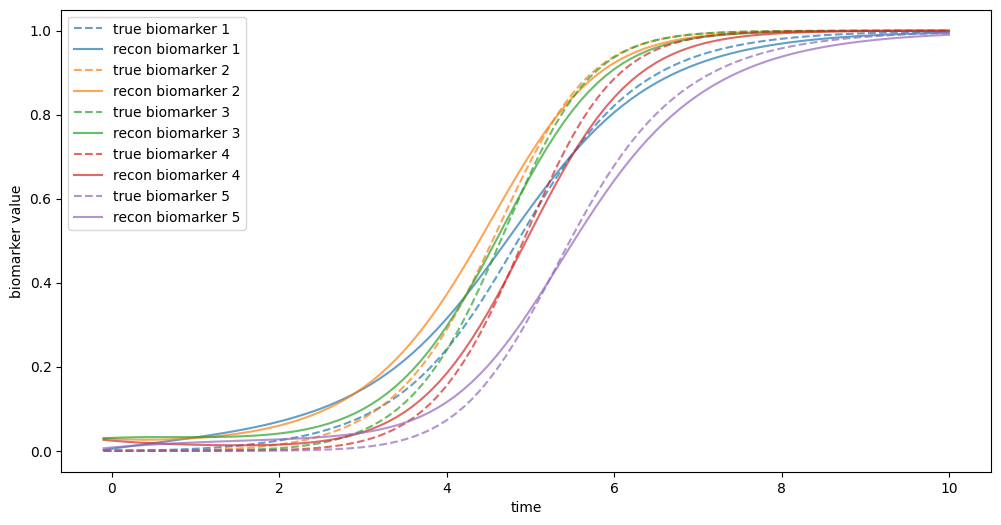

In [ ]:
from scipy.optimize import minimize

def lsq_x0(params, t_obs, x_obs, n_biomarkers, step=0.1, t_span=None):
    
    # if x0_fixed is None, it means we are optimizing both x0 (initial conditions) and f (forcing terms)
    # so we split the params array into the first n_biomarkers (x0) and the rest (f)
    # otherwise, if x0_fixed is provided, we don't optimize x0 and use it directly, only optimizing f
    
    x0 = params[:n_biomarkers]
    f = params[n_biomarkers:2 * n_biomarkers] 
    K_elements = params[2 * n_biomarkers:]

    # rebuild K from selected off-diagonal elements
    K = np.zeros((n_biomarkers, n_biomarkers))
    idx = 0

    # create first off-diagonal (A[i, i+1] and A[i+1, i])
    for i in range(n_biomarkers - 1):
        K[i, i + 1] = K_elements[idx]
        K[i + 1, i] = K_elements[idx]
        idx += 1

    # # create second off-diagonal (A[i, i+2] and A[i+2, i])
    # for i in range(n_biomarkers - 2):
    #     K[i, i + 2] = K_elements[idx]
    #     K[i + 2, i] = K_elements[idx]
    #     idx += 1

    x_pred = np.zeros((n_biomarkers, len(t_obs)))
    x = np.zeros((n_biomarkers, len(t_span)))
    x[:, 0] = x0  # set initial conditions

    # forward integration
    for i in range(len(t_span) - 1):
        dx_dt = multi_logistic_deriv_force(K, f, x[:, i])
        x[:, i + 1] = x[:, i] + dx_dt * step

    # interpolation to match observed timing
    for j in range(n_biomarkers):
        x_pred[j] = np.interp(t_obs, t_span, x[j])

    # compute residuals
    residuals = x_obs.flatten() - x_pred.flatten()
    return residuals

# initial guesses
x0_guess = np.zeros(n_biomarkers)  # assume biomarkers start close to 0
f_guess = np.zeros(n_biomarkers)  # forcing terms guessed as zeroes

# guess for selected K elements (first and second off-diagonals)
K_elements_guess = np.ones((n_biomarkers - 1) + (n_biomarkers - 2)) * 0.1  # small initial guess

# combine all guesses into one array
params_guess = np.concatenate([x0_guess, f_guess, K_elements_guess])

# bounds for x0, f, and selected K elements
bounds_x0 = [(0, 0.05)] * n_biomarkers
bounds_f = [(-0.1, 0.1)] * n_biomarkers
bounds_K_elements = [(0, 1)] * len(K_elements_guess)  # constrain K elements to be positive

bounds = bounds_x0 + bounds_f + bounds_K_elements

# optimize x0, f, and selected K elements
result = minimize(
    lambda params: np.sum(lsq_x0(params, t_obs, x_obs, n_biomarkers, step=0.1, t_span=t) ** 2),
    params_guess,
    method="L-BFGS-B",
    bounds=bounds
)

# extract fitted parameters
x0_fit = result.x[:n_biomarkers]
f_fit = result.x[n_biomarkers:2 * n_biomarkers]
K_elements_fit = result.x[2 * n_biomarkers:]

# rebuild K from fitted selected elements
K_fit = np.zeros((n_biomarkers, n_biomarkers))
idx = 0

# create first off-diagonal
for i in range(n_biomarkers - 1):
    K_fit[i, i + 1] = K_elements_fit[idx]
    K_fit[i + 1, i] = K_elements_fit[idx]
    idx += 1

# # create second off-diagonal
# for i in range(n_biomarkers - 2):
#     K_fit[i, i + 2] = K_elements_fit[idx]
#     K_fit[i + 2, i] = K_elements_fit[idx]
#     idx += 1

# copied from disease instantiation
x0_true = np.zeros(n_biomarkers)
f_true = np.zeros(n_biomarkers)
f_true[0] = 0.01

print("fitted x0: ", x0_fit)
print("true x0: ", x0_true)
print("\n")
print("fitted f: ", f_fit)
print("true f: ", f_true)
print("\n")
print("fitted K: \n", K_fit)
print("true K: \n", K)

# reconstruction
x_reconstructed = reconstruct_trajectories(x0_fit, f_fit, K_fit, t)

colors = plt.cm.tab10.colors

plt.figure(figsize=(12, 6))

for i in range(x_true.shape[0]):
    plt.plot(t, x_true[i], label=f"true biomarker {i+1}", linestyle="--", alpha=0.7, color=colors[i])
    plt.plot(t, x_reconstructed[i], label=f"recon biomarker {i+1}", alpha=0.7, color=colors[i])

plt.xlabel("time")
plt.ylabel("biomarker value")
plt.legend()
plt.show()
